# **Ultralytics YOLOv11를 활용한 Vehicle Trajectory Prediction**

## 1. 영상 다운로드

In [1]:
import gdown

file_id = "1nLSUY4Oqb_aI3fkVeTPQ2MLEuooMjT6n"
output_file = "video.zip"  # Replace "data_file.ext" with the desired output filename and extension

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1nLSUY4Oqb_aI3fkVeTPQ2MLEuooMjT6n
To: /content/video.zip
100%|██████████| 14.0M/14.0M [00:00<00:00, 89.2MB/s]


'video.zip'

## 2. 영상 재생

In [2]:
!unzip "/content/video.zip"

Archive:  /content/video.zip
  inflating: test.mp4                
  inflating: train_val.mp4           


In [3]:
!pip3 install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00


In [4]:
import ipywidgets
from ipywidgets import Image
from IPython.display import display

In [5]:
video_widget = ipywidgets.Video.from_file("/content/train_val.mp4")
display(video_widget)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00f7moov\x00\x00\x00lmvhd\x00\x00\x00…

## 3. 데이터셋 생성

### A. Ultralytics 설치

In [6]:
!pip3 install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

### B. Hyperparameter 설정

In [7]:
opt = {"video_size": 640, "seed":42, "train_val_ratio":0.9, "input_frame":40, "target_frame":10, "conf":0.05, "iou":0.05,
       "in_channels":2, "hid_channels":256, "out_channels":2, "num_layer":4, "p":0.1,
       "batch_size":256, "total_epoch":10, "lr":1e-4, "decay_rate":1e-2}

### C. Frame 별로 영상을 나누어 데이터셋 생성

#### i. 라이브러리 불러오기

In [8]:
from os import makedirs

import random
from random import shuffle

from collections import defaultdict

import cv2

import numpy as np
import pandas as pd

import torch

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### ii. 필요 함수 설정

In [9]:
def fix_seed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [10]:
class AverageMeter(object) :
  def __init__(self) :
    self.reset()

  def reset(self) :
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1) :
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum / self.count

#### iii. 영상 재생을 위한 Image 인스턴스 생성

In [11]:
video = Image()

#### iv. YOLOv11을 활용한 Vehicle 좌표 추출

https://docs.ultralytics.com/ko/datasets/detect/coco/#applications

In [12]:
# Load Pretrained YOLOv11 Model Weight
yolo = YOLO("yolo11m.pt")
yolo.info()

# Load Video
video_path = "/content/train_val.mp4"
cap = cv2.VideoCapture(video_path)

# Save Object Tracking Results
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(f"/content/tracking_results.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS), (opt["video_size"], opt["video_size"]))

# Create Dictionary & List Instance
track_history = defaultdict(lambda: [])
data = []

display(video)

with torch.no_grad() :
  while cap.isOpened() :
    # Retrieve Frame
    ret, frame = cap.read()

    if ret :
      # Get Object Tracking Results
      results = yolo.track(frame, persist=True, imgsz=opt["video_size"], conf=opt["conf"], iou=opt["iou"], verbose=False)

      # Get the Boxes and Track IDs
      boxes = results[0].boxes.xywh.cpu()
      track_ids = results[0].boxes.id.int().cpu().tolist()
      cls_ids = results[0].boxes.cls.int().cpu().tolist()

      # Visualize the Results on the Frame
      annotated_frame = results[0].plot()
      out.write(annotated_frame)
      annotated_frame = cv2.imencode(".jpg", annotated_frame)[1].tobytes()
      video.value = annotated_frame

      # Plot the tracks
      for box, track_id, cls_id in zip(boxes, track_ids, cls_ids) :
        if cls_id == 2 or cls_id == 5 or cls_id == 7 : # Car / Truck / Bus
          x, y, w, h = box # Bounding Box Info
          track = track_history[track_id]
          x, y = float(x), float(y)
          track.append((x, y)) # (x, y) Center Point

          if len(track) > (opt["input_frame"] + opt["target_frame"]) : # Input Frames + Target Frames
            data.append(track) # Add Data
            track.pop(0)
    else:
        break

cap.release()

100%|██████████| 38.8M/38.8M [00:00<00:00, 437MB/s]


YOLO11m summary: 231 layers, 20,114,688 parameters, 0 gradients, 68.5 GFLOPs


Image(value=b'')

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect



### D. Frame을 기준으로 데이터셋 생성

In [13]:
# Fix Seed
fix_seed(opt["seed"])

# Shuffle Data
shuffle(data)

# Compute Training Dataset Size
train_len = int(len(data)*opt["train_val_ratio"])

# Split Training & Validation Dataset
train_df, val_df = pd.DataFrame(data=data[:train_len]), pd.DataFrame(data=data[train_len:])

# Replace Column Names
col_name = {}
for i in range(opt["input_frame"] + opt["target_frame"]) :
  col_name[i] = f"frame_{i}"

# Create Directory
save_dir = "/content/csv"
makedirs(save_dir, exist_ok=True)

# Save Training & Validation Dataset
train_df, val_df = train_df.rename(columns=col_name), val_df.rename(columns=col_name)
train_df.to_csv(f"{save_dir}/train_dataset.csv", index=False), val_df.to_csv(f"{save_dir}/val_dataset.csv", index=False)

(None, None)

### E. 데이터셋 살펴보기

In [14]:
train_df.head(10)

,frame_0,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9,...,frame_40,frame_41,frame_42,frame_43,frame_44,frame_45,frame_46,frame_47,frame_48,frame_49
0,"(315.57525634765625, 378.82183837890625)","(318.38873291015625, 381.59454345703125)","(320.7835693359375, 384.222412109375)","(323.8518371582031, 386.9391784667969)","(327.35418701171875, 389.8048400878906)","(329.9205322265625, 392.5850524902344)","(333.77996826171875, 395.8851318359375)","(336.20257568359375, 399.2821044921875)","(340.21917724609375, 402.35272216796875)","(343.807861328125, 405.68603515625)",...,"(530.73193359375, 548.704833984375)","(534.933837890625, 551.5103149414062)","(539.3401489257812, 554.8899536132812)","(543.5337524414062, 558.918701171875)","(548.1282958984375, 563.1009521484375)","(553.1172485351562, 566.8450927734375)","(558.2986450195312, 571.764892578125)","(563.900146484375, 575.5530395507812)","(570.8463134765625, 579.3045654296875)","(576.8731689453125, 581.6202392578125)"
1,"(305.10821533203125, 361.33428955078125)","(307.8295593261719, 363.4855041503906)","(310.3300476074219, 366.2764892578125)","(313.2903137207031, 369.33172607421875)","(316.1473693847656, 371.3937072753906)","(319.4663391113281, 373.67144775390625)","(322.49554443359375, 375.6054992675781)","(325.8077087402344, 377.6509094238281)","(329.23406982421875, 381.1292724609375)","(332.3291931152344, 386.8487243652344)",...,"(507.73291015625, 523.6182861328125)","(510.5734558105469, 525.8488159179688)","(529.2669067382812, 529.4174194335938)","(521.942626953125, 530.799560546875)","(522.7451171875, 532.1580200195312)","(527.9044189453125, 535.9520874023438)","(531.3208618164062, 538.6381225585938)","(536.0428466796875, 543.1156616210938)","(540.5068359375, 547.6088256835938)","(545.2060546875, 550.3820190429688)"
2,"(369.6778564453125, 209.86947631835938)","(369.7207946777344, 209.88702392578125)","(369.84967041015625, 209.863037109375)","(369.8648986816406, 209.86590576171875)","(369.73785400390625, 209.80923461914062)","(369.56402587890625, 209.63572692871094)","(369.5439453125, 209.57118225097656)","(369.6422119140625, 209.548095703125)","(369.78887939453125, 209.56292724609375)","(369.7274475097656, 209.55227661132812)",...,"(372.7494201660156, 210.08560180664062)","(372.9587097167969, 210.07662963867188)","(371.2685546875, 209.99728393554688)","(370.7247314453125, 209.85707092285156)","(370.38311767578125, 209.9344482421875)","(370.12908935546875, 209.86032104492188)","(370.15655517578125, 210.0282745361328)","(369.848876953125, 209.95187377929688)","(370.0167236328125, 209.9004364013672)","(369.9970703125, 209.877685546875)"
3,"(351.038818359375, 187.70533752441406)","(351.0325622558594, 187.71888732910156)","(351.0050964355469, 187.73782348632812)","(350.9739990234375, 187.7362060546875)","(350.97064208984375, 187.77496337890625)","(350.93408203125, 187.79403686523438)","(350.97021484375, 187.80825805664062)","(350.9998779296875, 187.80258178710938)","(351.0875244140625, 187.72430419921875)","(351.0987548828125, 187.72055053710938)",...,"(350.70928955078125, 188.0666046142578)","(350.64300537109375, 187.99404907226562)","(350.4311828613281, 187.94236755371094)","(350.2901611328125, 187.90435791015625)","(350.38897705078125, 187.8856201171875)","(350.49383544921875, 187.8079376220703)","(350.4681701660156, 187.7292022705078)","(350.3040466308594, 187.7276153564453)","(350.27801513671875, 187.75347900390625)","(350.276611328125, 187.7682342529297)"
4,"(304.8376159667969, 146.21041870117188)","(304.93023681640625, 146.1534881591797)","(305.00042724609375, 146.09031677246094)","(305.0745544433594, 145.79547119140625)","(305.09576416015625, 145.700439453125)","(305.04541015625, 145.66522216796875)","(304.9669189453125, 145.5970458984375)","(304.79656982421875, 145.57455444335938)","(304.86016845703125, 145.4983367919922)","(304.76910400390625, 145.2805938720703)",...,"(305.06365966796875, 141.2803497314453)","(304.9383544921875, 141.06048583984375)","

## 4. Custom Dataloader 생성

In [15]:
from ast import literal_eval

from torch.utils.data import Dataset

In [16]:
class LoadDataset(Dataset) :
  def __init__(self, opt, for_val) :
    # Inheritance
    super(LoadDataset, self).__init__()

    # Initialize Variable
    self.opt = opt

    # Load CSV
    self.data = self.load_csv("/content/csv/val_dataset.csv" if for_val else "/content/csv/train_dataset.csv")

  def load_csv(self, csv_dir) :
    # Convert into Pillow Image
    data = pd.read_csv(csv_dir)

    return data

  def __getitem__(self, index) :
    # Split Sequence
    input, target = self.data.iloc[index][:self.opt["input_frame"]], self.data.iloc[index][self.opt["input_frame"]:]

    # Convert to PyTorch Tensor
    input_x, input_y = [literal_eval(i)[0] for i in input], [literal_eval(i)[1] for i in input]
    input_x, input_y = torch.tensor(input_x).unsqueeze(-1), torch.tensor(input_y).unsqueeze(-1)

    target_x, target_y = [literal_eval(i)[0] for i in target], [literal_eval(i)[1] for i in target]
    target_x, target_y = torch.tensor(target_x).unsqueeze(-1), torch.tensor(target_y).unsqueeze(-1)

    # Apply Min-Max Normalization
    input_x, input_y = self.min_max_norm(input_x, 0, self.opt["video_size"]), self.min_max_norm(input_y, 0, self.opt["video_size"])
    target_x, target_y = self.min_max_norm(target_x, 0, self.opt["video_size"]), self.min_max_norm(target_y, 0, self.opt["video_size"])

    # Concatenate Tensor ([#Seq, 2])
    input = torch.cat([input_x, input_y], dim=-1)
    target = torch.cat([target_x, target_y], dim=-1)

    return input, target

  def __len__(self) :
    # Get Number of Data
    return self.data.shape[0]

  def min_max_norm(self, input, min, max) :
    output = (input-min)/(max-min)

    return output

## 5. LSTM Model

### A. Trajectory 예측을 위한 모델 생성

In [17]:
from torch import nn

In [18]:
class LSTM(nn.Module) :
  def __init__(self, opt) :
    # Inheritance
    super(LSTM, self).__init__()

    # Initialize Variable
    self.opt = opt

    # Create LSTM Layer Instance
    self.lstm = nn.LSTM(opt["hid_channels"], opt["hid_channels"], num_layers=opt["num_layer"], bidirectional=False, batch_first=True, dropout=opt["p"] if opt["num_layer"] != 1 else 0)
    self.bilstm = nn.LSTM(opt["hid_channels"], opt["hid_channels"]//2, num_layers=opt["num_layer"], bidirectional=True, batch_first=True, dropout=opt["p"] if opt["num_layer"] != 1 else 0)

    # Create FC Layer Instance
    self.input2lstm = nn.Linear(opt["in_channels"], opt["hid_channels"])
    self.input2bilstm = nn.Linear(opt["in_channels"], opt["hid_channels"])
    self.input2output = nn.Linear(opt["in_channels"], opt["hid_channels"])
    self.fc0 = nn.Linear(opt["hid_channels"]*2, opt["hid_channels"], bias=False)
    self.fc1 = nn.Linear(opt["hid_channels"], opt["hid_channels"], bias=False)
    self.fc2 = nn.Linear(opt["hid_channels"], opt["out_channels"])

    # Create Layer Normalization Layer Instance
    self.norm0 = nn.LayerNorm(opt["hid_channels"])
    self.norm1 = nn.LayerNorm(opt["hid_channels"])

    # Create Activation Layer Instance
    self.act = nn.ReLU(inplace=True)

  def forward(self, input) :
    lstm_input, bilstm_input = self.input2lstm(input), self.input2bilstm(input)

    lstm_h0 = torch.zeros(self.opt["num_layer"], lstm_input.size(0), self.opt["hid_channels"]).to(input.device)
    lstm_c0 = torch.zeros(self.opt["num_layer"], lstm_input.size(0), self.opt["hid_channels"]).to(input.device)

    bilstm_h0 = torch.zeros(self.opt["num_layer"]*2, bilstm_input.size(0), self.opt["hid_channels"]//2).to(input.device)
    bilstm_c0 = torch.zeros(self.opt["num_layer"]*2, bilstm_input.size(0), self.opt["hid_channels"]//2).to(input.device)

    lstm_output, _ = self.lstm(lstm_input, (lstm_h0, lstm_c0))
    bilstm_output, _ = self.bilstm(bilstm_input, (bilstm_h0, bilstm_c0))

    output = self.norm0(self.act(self.fc0(torch.cat([lstm_output, bilstm_output], dim=-1))))
    output = self.norm1(self.act(self.fc1(output))) + self.input2output(input)
    output = self.fc2(output)

    return output

## 6. Trajectory 예측 모델 훈련 진행

In [19]:
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import DataLoader

from tqdm import tqdm

# Parameters : 3,886,850
Device Type : cuda


[10/10] [Val] < Loss:0.0041 >: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


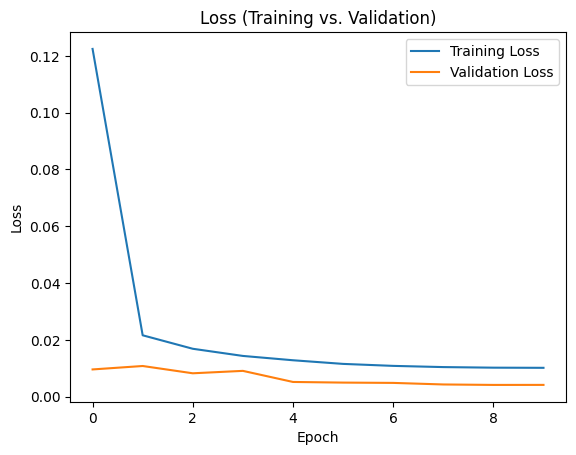

In [20]:
fix_seed(opt["seed"])

# Load Training Dataset
train_dataset = LoadDataset(opt, for_val=False)
train_loader = DataLoader(train_dataset, batch_size=opt["batch_size"], drop_last=True, shuffle=True)

# Load Validation Dataset
val_dataset = LoadDataset(opt, for_val=True)
val_loader = DataLoader(val_dataset, batch_size=opt["batch_size"], drop_last=False, shuffle=False)

# Fix Seed
fix_seed(opt["seed"])

# Create Model Instance
model = LSTM(opt)

# Compute Number of Parameters
num_parameter = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"# Parameters : {num_parameter:,}")

# Create Optimizer Instance
optimizer = optim.Adam(model.parameters(), lr=opt["lr"])

# Create Scheduler Instance
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                 T_max=opt["total_epoch"]*len(train_loader),
                                                 eta_min=opt["lr"]*opt["decay_rate"])

# Create Loss Function Instance
criterion = nn.L1Loss()

# Determine Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Type : {device}")

# Assign Device
model = model.to(device)

# Create Average Meter Instance
train_loss, val_loss = AverageMeter(), AverageMeter()

# Create List Instance
train_loss_list, val_loss_list = [], []

# Create Directory
ckpt_dir, graph_dir = "ckpt/lstm", "result/lstm"
makedirs(ckpt_dir, exist_ok=True), makedirs(graph_dir, exist_ok=True)

# Set Best loss
best_loss = np.inf

# Start Training
for epoch in range(1, opt["total_epoch"]+1) :
  # Create TQDM Dataloader Instance
  train_bar = tqdm(train_loader)

  # Reset Average Meter Instance
  train_loss.reset()

  # Set Training Mode
  model.train()

  # Training Phase
  for data in train_bar :
    # Load Dataset
    input, target = data

    # Assign Device
    input, target = input.to(device), target.to(device)

    # Set Gradient to 0
    optimizer.zero_grad()

    # Get Prediction
    pred = model(input)

    # Compute Loss
    loss = criterion(pred[:,-opt["target_frame"]:,:], target)

    # Back-Propagation
    loss.backward()

    # Update Weight
    optimizer.step()

    # Update Learning Rate Scheduler
    scheduler.step()

    # Compute Averaged Loss
    train_loss.update(loss.detach().cpu().item(), opt["batch_size"])

    # Update Progess Bar Status
    train_bar.set_description(desc=f"[{epoch}/{opt['total_epoch']}] [Train] < Loss:{train_loss.avg:.4f} >")

  # Add Training Loss
  train_loss_list.append(train_loss.avg)

  # Create TQDM Dataloader Instance
  val_bar = tqdm(val_loader)

  # Reset Average Meter Instance
  val_loss.reset()

  # Set Validation Mode
  model.eval()

  # Validation Phase
  for data in val_bar :
    # Load Dataset
    input, target = data

    # Assign Device
    input, target = input.to(device), target.to(device)

    with torch.no_grad() :
      # Get Prediction
      pred = model(input)

    # Compute Loss
    loss = criterion(pred[:,-opt["target_frame"]:,:], target)

    # Compute Averaged Loss
    val_loss.update(loss.detach().cpu().item(), opt["batch_size"])

    # Update Progess Bar Status
    val_bar.set_description(desc=f"[{epoch}/{opt['total_epoch']}] [Val] < Loss:{val_loss.avg:.4f} >")

  # Add Validation Loss
  val_loss_list.append(val_loss.avg)

  # Save Network
  if val_loss.avg < best_loss :
    best_loss = val_loss.avg
    torch.save(model.state_dict(), f"{ckpt_dir}/best.pth")
  torch.save(model.state_dict(), f"{ckpt_dir}/latest.pth")

  # Plot Training vs. Validation Loss Graph
  plt.clf()
  plt.plot(np.arange(epoch), train_loss_list, label="Training Loss")
  plt.plot(np.arange(epoch), val_loss_list, label="Validation Loss")
  plt.title("Loss (Training vs. Validation)")
  plt.xlabel("Epoch"), plt.ylabel("Loss")
  plt.legend(loc="best")
  plt.savefig(f"{graph_dir}/loss.png")

## 7. Valid 데이터셋을 활용하여 Inference 진행

### A. Pretrained Model 다운로드 (Best Model @ Epoch-50)

In [21]:
file_id = "1ij2rk2C4XQvj1Nj2GyoYkD3foDVeqwuE"
output_file = "best_epoch_50.pth"  # Replace "data_file.ext" with the desired output filename and extension

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1ij2rk2C4XQvj1Nj2GyoYkD3foDVeqwuE
To: /content/best_epoch_50.pth
100%|██████████| 15.6M/15.6M [00:00<00:00, 163MB/s]


'best_epoch_50.pth'

In [22]:
opt["batch_size"] = 8

In [23]:
# Fix Seed
fix_seed(opt["seed"])

# Load Validation Dataset
val_dataset = LoadDataset(opt, for_val=True)
val_loader = DataLoader(val_dataset, batch_size=opt["batch_size"], drop_last=False, shuffle=False)

# Fix Seed
fix_seed(opt["seed"])

# Create Model Instance
model = LSTM(opt)

# Load Pretraind Weight
model.load_state_dict(torch.load(f"/content/best_epoch_50.pth"), strict=True)

# Determine Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Type : {device}")

# Assign Device
model = model.to(device)

# Create Directory
graph_dir = "result/val"
makedirs(graph_dir, exist_ok=True)

# Start Test Phase
val_bar = tqdm(val_loader)

# Start Test Phase
for index, data in enumerate(val_bar) :
  # Load Dataset
  input, target = data

  # Assign Device
  input, target = input.to(device), target.to(device)

  with torch.no_grad() :
    # Get Prediction
    pred = model(input)

    # Affine Transformation
    input = (input.detach().cpu().numpy()*639).astype("int32")

    # Affine Transformation
    pred = (pred[:,-opt["target_frame"]:,:].clamp(0,1).detach().cpu().numpy()*639).astype("int32")

    # Affine Transformation
    target = (target.detach().cpu().numpy()*639).astype("int32")

    # Update Progess Bar Status
    val_bar.set_description(desc=f"[Test] < Updating Results >")

  # Result Visualization
  for i in range(pred.shape[0]) :
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(list(input[i,:,0])+list(pred[i,:,0]), list(input[i,:,1])+list(pred[i,:,1]), "r", label="Prediction")
    plt.plot(list(input[i,:,0])+list(target[i,:,0]), list(input[i,:,1])+list(target[i,:,1]), "g", label="Ground-Truth")
    plt.xlabel("Local X Coordinate")
    plt.ylabel("Local Y Coordinate")
    plt.title("Trajectory Tracking Prediction")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/trajectory_index_{index}_batch_{i}.png")
    plt.close()

  if index >= 10 :
    break

Device Type : cuda


[Test] < Updating Results >:   4%|▍         | 10/264 [00:12<05:05,  1.20s/it]


<Figure size 640x480 with 0 Axes>

### B. Trajectory Prediction 결과 시각화 (그래프)

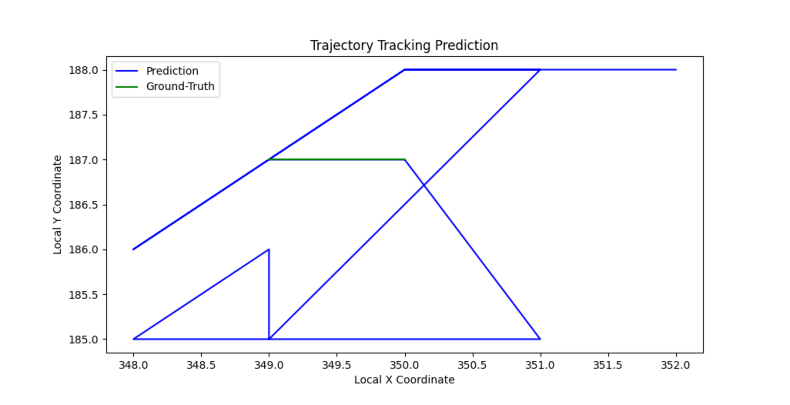

In [24]:
result_graph = cv2.imread("/content/result/val/trajectory_index_0_batch_0.png")
plt.figure(figsize=(10, 5))
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.imshow(result_graph)
plt.show()

## 8. Test 데이터셋을 활용하여 추론 및 결과 시각화

In [25]:
video = Image()

In [26]:
# Load Pretrained YOLOv11 Model Weight
yolo = YOLO("yolo11m.pt")
yolo.info()

# Load Video
video_path = "/content/test.mp4"
cap = cv2.VideoCapture(video_path)

# Create Directory for Saving Results
save_dir = "result/lstm"
makedirs(save_dir, exist_ok=True)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(f"{save_dir}/tracking_prediction.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS), (opt["video_size"], opt["video_size"]))

# Create LSTM Model Instance
lstm = LSTM(opt).eval()

# Load Pretrained LSTM Model Weight
weights = torch.load("/content/best_epoch_50.pth")
lstm.load_state_dict(weights, strict=True)

# Determine Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Type : {device}")

# Assign Device
lstm = lstm.to(device)

# Create Dictionary Instance
track_history = defaultdict(lambda: [])
lstm_track_history = defaultdict(lambda: [])

display(video)

with torch.no_grad() :
  while cap.isOpened() :
    # Retrieve Frame
    ret, frame = cap.read()

    if ret :
      # Get Object Tracking Results
      results = yolo.track(frame, persist=True, imgsz=opt["video_size"], conf=opt["conf"], iou=opt["iou"], verbose=False)

      # Get the Boxes and Track IDs
      boxes = results[0].boxes.xywh.cpu()
      track_ids = results[0].boxes.id.int().cpu().tolist()
      cls_ids = results[0].boxes.cls.int().cpu().tolist()

      # Visualize the Results on the Frame
      annotated_frame = results[0].plot()

      # Plot the tracks
      for box, track_id, cls_id in zip(boxes, track_ids, cls_ids) :
        if cls_id == 2 or cls_id == 5 or cls_id == 7 : # Car / Truck / Bus
          x, y, w, h = box # Bounding Box Info
          track = track_history[track_id]
          lstm_track = lstm_track_history[track_id]
          track.append((float(x), float(y))) # (x, y) Center Point
          if len(track) > opt["input_frame"] :
            track.pop(0)
            input = np.hstack(track).astype(np.int32).reshape((1, -1, 2)) # Get Input Data
            input = torch.tensor(input).to(device)/639 # Min-Max Norm Input Data
            pred = lstm(input)[:,-opt["target_frame"]:,:].clamp(0,1).cpu().detach().numpy().reshape(-1, 2)*639 # Inference & Affine Prediction
            for i in range(pred.shape[0]) :
                lstm_track.append((float(pred[i][0]), float(pred[i][1]))) # Add Predictions

          # Draw the Tracking Lines
          points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
          cv2.polylines(annotated_frame, [points], isClosed=False, color=(0, 0, 255), thickness=2)

          # Draw the Predicted Tracking Lines
          if len(lstm_track) == opt["target_frame"] :
            pred_points = np.hstack(lstm_track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotated_frame, [pred_points], isClosed=False, color=(255, 0, 0), thickness=2)
          lstm_track_history[track_id] = []

      # Show Object Tracking Results
      out.write(annotated_frame)
      annotated_frame = cv2.imencode(".jpg", annotated_frame)[1].tobytes()
      video.value = annotated_frame

    else:
        break

cap.release()

YOLO11m summary: 231 layers, 20,114,688 parameters, 0 gradients, 68.5 GFLOPs
Device Type : cuda


Image(value=b'')

## 개인 실습

### YOLOv11 모델과 LSTM 모델을 최대한 가볍게 만들어서 동영상 처리 속도를 최대한으로 빠르게 만들어보세요.